# **Import Library**

In [ ]:
!pip install pandas nltk tensorflow scikit-learn
!pip install sastrawi

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderQueryError
from tqdm import tqdm
from collections import Counter
from google.colab import drive
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import nltk
from nltk.corpus import stopwords
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf
from collections import Counter
import warnings
from IPython.display import display


warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


# **Load Dataset**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path ke file sumber
file_path = '/content/drive/My Drive/TA_Analisis_Sentimen/Fix_Labeled_Dataset_Crawling_Eruption Of Marapi.csv'

# Baca file CSV
df = pd.read_csv(file_path, delimiter=';')

Mounted at /content/drive


# **Praprocessing**

In [ ]:
# 1.1 Data Cleaning
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+|https t|t co', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|\#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    return text

# 1.2 Case Folding
def case_folding(text):
    return text.lower()

# 1.3 Tokenizing
def tokenize_text(text):
    return text.split()

# 1.4 Normalizing
def normalize_text(tokens):
    abbreviation_dict = {
        'gk': 'nggak', 'ga': 'nggak', 'g': 'nggak','ngga': 'nggak', 'dlm': 'dalam', 'dgn': 'dengan', 'krn': 'karena', 'sdh': 'sudah', 'udh': 'sudah',
        'blm': 'belum', 'aja': 'saja', 'sy': 'saya', 'aku': 'saya', 'q': 'saya', 'kamu': 'anda', 'km': 'kamu',
        'bgt': 'banget', 'trs': 'terus', 'sm': 'sama', 'org': 'orang', 'jg': 'juga', 'bs': 'bisa', 'gmn': 'gimana',
        'gimana': 'bagaimana', 'tp': 'tapi', 'y': 'ya', 'smg': 'semoga', 'hrs': 'harus', 'lbh': 'lebih', 'jgn': 'jangan',
        'pd': 'pada', 'utk': 'untuk', 'gmana': 'bagaimana', 'klu': 'kalau', 'klo': 'kalau', 'dl': 'dulu', 'dtg': 'datang',
        'bgmn': 'bagaimana', 'nih': 'ini', 'pls': 'tolong', 'btw': 'ngomong-ngomong', 'ya': 'iya', 'si': 'sih',
        'brp': 'berapa', 'tmn': 'teman', 'bbrp': 'beberapa', 'trmksh': 'terima kasih', 'makasih': 'terima kasih',
        'mks': 'makasih', 'sblm': 'sebelum', 'mo': 'mau', 'mlm': 'malam', 'pagi': 'selamat pagi',
        'siang': 'selamat siang', 'sore': 'selamat sore', 'malem': 'malam', 'ok': 'oke', 'oke': 'baik',
        'thx': 'terima kasih', 'wkwk': 'tertawa', 'lol': 'tertawa', 'he': 'haha', 'ah': 'ah', 'gt': 'gitu',
        'om': 'paman', 'pak': 'bapak', 'bu': 'ibu', 'dr': 'dokter', 'msh': 'masih', 'kl': 'kalau', 'kmrn': 'kemarin',
        'bsk': 'besok', 'gw': 'saya', 'loe': 'kamu', 'loh': 'lho', 'n': 'dan', 'yg': 'yang', 'knp': 'kenapa', 'tdk': 'tidak'
    }
    return [abbreviation_dict.get(word, word) for word in tokens]

# 1.5 Stopword Removal
nltk.download('stopwords')

stop_words_id = set(stopwords.words('indonesian'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words_id]

# 1.6 Stemming
def sastrawi_stem(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    return [stemmer.stem(word) for word in tokens]

# Apply all steps to the text
df['cleaned_text'] = df['full_text'].apply(clean_text)
df['lowered_text'] = df['cleaned_text'].apply(case_folding)
df['tokenized_text'] = df['lowered_text'].apply(tokenize_text)
df['normalized_text'] = df['tokenized_text'].apply(normalize_text)
df['filtered_text'] = df['normalized_text'].apply(remove_stopwords)
df['stemmed_text'] = df['filtered_text'].apply(sastrawi_stem)
df['processed_text'] = df['stemmed_text'].apply(lambda tokens: ' '.join(tokens))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
display(df)

,full_text,Location,Sentimen,cleaned_text,lowered_text,tokenized_text,normalized_text,filtered_text,stemmed_text,processed_text
0,Uda Tomi dan Uda Andika ini harusnya diangkat ...,"Sumatera Barat, Indonesia",Negatif,Uda Tomi dan Uda Andika ini harusnya diangkat ...,uda tomi dan uda andika ini harusnya diangkat ...,"[uda, tomi, dan, uda, andika, ini, harusnya, d...","[uda, tomi, dan, uda, andika, ini, harusnya, d...","[uda, tomi, uda, andika, diangkat, pns, basarn...","[uda, tom, uda, andika, angkat, pns, basarnas,...",uda tom uda andika angkat pns basarnas sih jal...
1,aku belum pernah nanjak terhalang restu orang ...,"Sumatera Barat, Indonesia",Negatif,aku belum pernah nanjak terhalang restu orang ...,aku belum pernah nanjak terhalang restu orang ...,"[aku, belum, pernah, nanjak, terhalang, restu,...","[saya, belum, pernah, nanjak, terhalang, restu...","[nanjak, terhalang, restu, orang, tua, gunung,...","[nanjak, halang, restu, orang, tua, gunung, ma...",nanjak halang restu orang tua gunung marapi er...
2,Kucing emas korban jerat kini bebas. Namun men...,"Sumatera Barat, Indonesia",Negatif,Kucing emas korban jerat kini bebas Namun meng...,kucing emas korban jerat kini bebas namun meng...,"[kucing, emas, korban, jerat, kini, bebas, nam...","[kucing, emas, korban, jerat, kini, bebas, nam...","[kucing, emas, korban, jerat, bebas, hewan, la...","[kucing, emas, korban, jerat, bebas, hewan, la...",kucing emas korban jerat bebas hewan langka ha...
3,Pas banget pertama turun ke payakumbuh itu kit...,"Payakumbuh, Sumatera Barat",Negatif,Pas banget pertama turun ke payakumbuh itu kit...,pas banget pertama turun ke payakumbuh itu kit...,"[pas, banget, pertama, turun, ke, payakumbuh, ...","[pas, banget, pertama, turun, ke, payakumbuh, ...","[pas, banget, turun, payakumbuh, rencanain, ta...","[pas, banget, turun, payakumbuh, rencanain, ta...",pas banget turun payakumbuh rencanain tanggal ...
4,Hal yang paling aku takutkan saat ini apalagi ...,"Jakarta, Indonesia",Negatif,Hal yang paling aku takutkan saat ini apalagi ...,hal yang paling aku takutkan saat ini apalagi ...,"[hal, yang, paling, aku, takutkan, saat, ini, ...","[hal, yang, paling, saya, takutkan, saat, ini,...","[takutkan, temenku, korban, erupsi, marapi, se...","[takut, temenku, korban, erupsi, marapi, moga,...",takut temenku korban erupsi marapi moga selamat
...,...,...,...,...,...,...,...,...,...,...
983,Gunung Sinabung Meletus 2 Kali Gunung Marapi E...,"Sumatera Barat, Indonesia",Negatif,Gunung Sinabung Meletus Kali Gunung Marapi Er...,gunung sinabung meletus kali gunung marapi er...,"[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sabung, letus, kali, gunung, marapi, ...",gunung sabung letus kali gunung marapi erupsi ...
984,Gunung Sinabung Meletus 2 Kali Gunung Marapi E...,"Garut, Indonesia",Negatif,Gunung Sinabung Meletus Kali Gunung Marapi Er...,gunung sinabung meletus kali gunung marapi er...,"[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sabung, letus, kali, gunung, marapi, ...",gunung sabung letus kali gunung marapi erupsi ...
985,Marapi Keluarkan Asap Hitam Warga Khawatir: En...,"Sumatera Barat, Indonesia",Negatif,Marapi Keluarkan Asap Hitam Warga Khawatir Ena...,marapi keluarkan asap hitam warga khawatir ena...,"[marapi, keluarkan, asap, hitam, warga, khawat...","[marapi, keluarkan, asap, hitam, warga, khawat...","[marapi, keluarkan, asap, hitam, warga, khawat...","[marapi, keluar, asap, hitam, warga, khawatir,...",marapi keluar asap hitam warga khawatir enam m...
986,Marapi Keluarkan Asap Hitam Warga Khawatir: En...,"Sumatera Barat, Indonesia",Negatif,Marapi Keluarkan Asap Hitam Warga Khawatir Ena...,marapi keluarkan asap hitam warga khawatir ena...,"[marapi, keluarkan, asap, hitam, warga, khawat...","[marapi, keluarkan, asap, hitam,

# **Aspek Aspek**

In [ ]:
aspect_keywords = {
    'Kebutuhan Dasar': [
        'Tempat tinggal', 'hunian', 'rumah', 'pengungsian', 'bangun', 'pemukiman', 'bangunan',
        'medis', 'obat', 'sakit', 'penyakit', 'kesehatan', 'dokter', 'masker',
        'makan', 'bahan pokok', 'lapar', 'pangan', 'makanan', 'dapur', 'Dapur', 'sembako',
        'air', 'minum', 'haus',
        'listrik', 'padam',
        'jalan', 'transportasi'
    ],
    'Respon dan Tindakan': [
        'santunan', 'bantuan', 'bantuan sosial', 'penyelamatan', 'relawan', 'sar', 'evakuasi', 'pertolongan',
        'membantu', 'mengevakuasi', 'asuransi'
    ],
    'Dampak dan Kerusakan': [
        'kerugian', 'dampak', 'kerusakan', 'hilang', 'bangunan', 'rumah', 'korban', 'meninggal', 'luka', 'jiwa', 'selamat'
    ],
    'Cuaca dan Alam': [
        'cuaca', 'hujan', 'tanah', 'gunung', 'pohon', 'abu', 'abuu', 'asap', 'siang', 'malam', 'pagi', 'sore', 'jurang',
        'erupsi', 'banjir', 'membaik', 'sembuh', 'longsor', 'vulkanik', 'gunuang', 'meletus', 'gempa'
    ]
}

df['processed_text'] = df['full_text']

def classify_aspect(text):
    for aspect, keywords in aspect_keywords.items():
        for keyword in keywords:
            if keyword.lower() in text.lower():
                return aspect
    return 'Lainnya'

df['Aspect'] = df['processed_text'].apply(classify_aspect)

# **Modeling**

In [ ]:
label_encoder = LabelEncoder()
df['Sentimen'] = label_encoder.fit_transform(df['Sentimen'])

aspects = ['Kebutuhan Dasar', 'Dampak dan Kerusakan', 'Respon dan Tindakan', 'Cuaca dan Alam']
kernels = ['linear', 'poly', 'rbf']
results = {}

for aspect in aspects:
    print(f"\nProcessing aspect: {aspect}")
    df_aspect = df[df['Aspect'] == aspect]
    if df_aspect.empty:
        print(f"No data for aspect: {aspect}")
        continue

    # TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    X = tfidf_vectorizer.fit_transform(df_aspect['processed_text'])
    y = df_aspect['Sentimen']

    # Check class distribution
    class_counts = Counter(y)
    if len(class_counts) < 2 or any(count < 2 for count in class_counts.values()):
        print(f"Skipping aspect {aspect} due to insufficient samples in one or more classes.")
        continue

    # Stratified K-Fold
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    aspect_results = {}

    for kernel in kernels:
        print(f"\nUsing kernel: {kernel}")
        scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # SMOTE dengan validasi jumlah sampel
            minority_class_count = y_train.value_counts().min()
            if minority_class_count > 1:
                smote = SMOTE(random_state=42, k_neighbors=min(1, minority_class_count - 1) if minority_class_count > 1 else 1)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            else:
                print(f"Skipping SMOTE for aspect {aspect} due to insufficient minority class samples.")
                X_train_resampled, y_train_resampled = X_train, y_train

            # SVM
            pipeline = ImbPipeline([
                ('svm', SVC(C=1, kernel=kernel, gamma='scale'))
            ])
            pipeline.fit(X_train_resampled, y_train_resampled)

            y_pred = pipeline.predict(X_test)

            scores['accuracy'].append(accuracy_score(y_test, y_pred))
            scores['precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
            scores['recall'].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
            scores['f1_score'].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

        # Average Metrics per kernel
        aspect_results[kernel] = {
            'accuracy': sum(scores['accuracy']) / len(scores['accuracy']),
            'precision': sum(scores['precision']) / len(scores['precision']),
            'recall': sum(scores['recall']) / len(scores['recall']),
            'f1_score': sum(scores['f1_score']) / len(scores['f1_score'])
        }

    results[aspect] = aspect_results



Processing aspect: Kebutuhan Dasar

Using kernel: linear

Using kernel: poly

Using kernel: rbf

Processing aspect: Dampak dan Kerusakan

Using kernel: linear

Using kernel: poly

Using kernel: rbf

Processing aspect: Respon dan Tindakan

Using kernel: linear

Using kernel: poly

Using kernel: rbf

Processing aspect: Cuaca dan Alam

Using kernel: linear

Using kernel: poly

Using kernel: rbf


# **Evaluasi**

In [ ]:
for aspect, kernel_results in results.items():
    print(f"\nAspect: {aspect}")
    for kernel, metrics in kernel_results.items():
        print(f"\nKernel: {kernel}")
        for metric, score in metrics.items():
            print(f"{metric.capitalize()}: {score:.4f}")


Aspect: Kebutuhan Dasar

Kernel: linear
Accuracy: 0.8911
Precision: 0.9077
Recall: 0.8911
F1_score: 0.8797

Kernel: poly
Accuracy: 0.7922
Precision: 0.7372
Recall: 0.7922
F1_score: 0.7388

Kernel: rbf
Accuracy: 0.8144
Precision: 0.7832
Recall: 0.8144
F1_score: 0.7737

Aspect: Dampak dan Kerusakan

Kernel: linear
Accuracy: 0.9242
Precision: 0.9238
Recall: 0.9242
F1_score: 0.9209

Kernel: poly
Accuracy: 0.8797
Precision: 0.8894
Recall: 0.8797
F1_score: 0.8580

Kernel: rbf
Accuracy: 0.8954
Precision: 0.8998
Recall: 0.8954
F1_score: 0.8812

Aspect: Respon dan Tindakan

Kernel: linear
Accuracy: 0.8038
Precision: 0.7931
Recall: 0.8038
F1_score: 0.7815

Kernel: poly
Accuracy: 0.7511
Precision: 0.7031
Recall: 0.7511
F1_score: 0.6792

Kernel: rbf
Accuracy: 0.7143
Precision: 0.5911
Recall: 0.7143
F1_score: 0.6162

Aspect: Cuaca dan Alam

Kernel: linear
Accuracy: 0.9422
Precision: 0.9240
Recall: 0.9422
F1_score: 0.9263

Kernel: poly
Accuracy: 0.9370
Precision: 0.8961
Recall: 0.9370
F1_score: 0.9

# **Visualisasi**

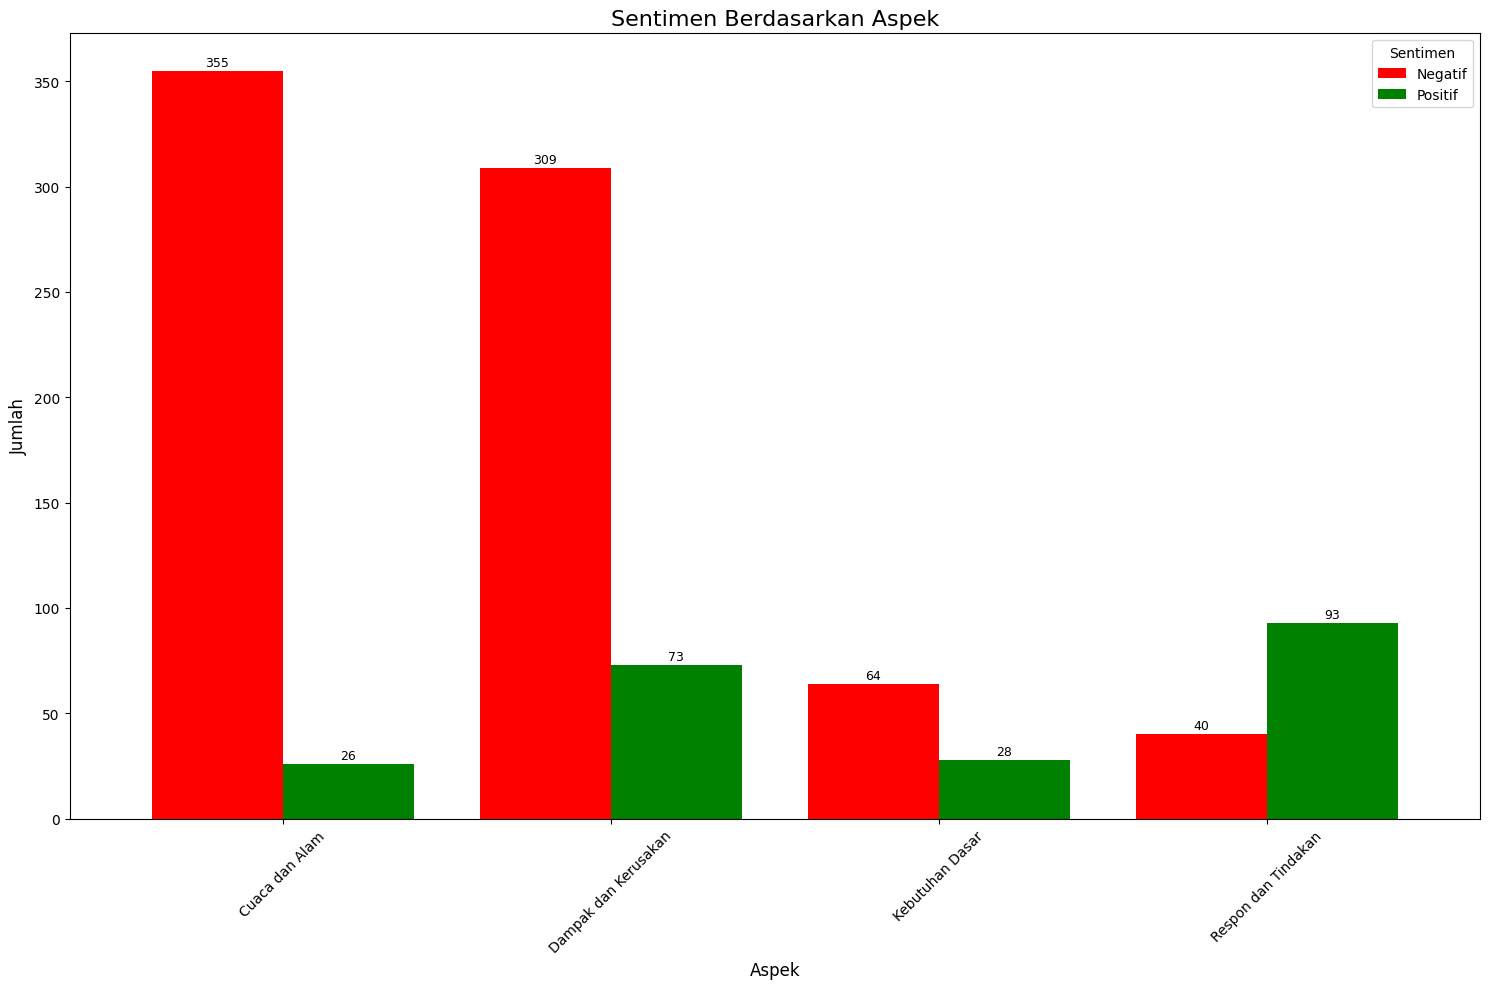

In [ ]:
# Visualisasi Jumlah Sentimen Pada Masing Masing Aspek
aspect_sentiment_counts = df.groupby(['Aspect', 'Sentimen']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(15, 10))

aspect_sentiment_counts.plot(kind='bar', ax=ax, color=['red', 'green'], width=0.8)

for i, bar in enumerate(ax.patches):
    if bar.get_height() > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            int(bar.get_height()),
            ha='center', va='bottom', fontsize=9
        )

ax.set_title("Sentimen Berdasarkan Aspek", fontsize=16)
ax.set_xlabel("Aspek", fontsize=12)
ax.set_ylabel("Jumlah", fontsize=12)
ax.legend(["Negatif", "Positif"], title="Sentimen", fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

plt.show()

In [ ]:
# Visualisasi Geospasial Aspek Dominan Pada Masing Masing Daerah

df['Sentimen'] = label_encoder.inverse_transform(df['Sentimen'])

geolocator = Nominatim(user_agent="geoapi")

def get_coordinates(location):
    try:
        if not location or pd.isna(location):
            return None
        loc = geolocator.geocode(location, timeout=10)
        if loc:
            return loc.latitude, loc.longitude
        else:
            return None
    except (GeocoderTimedOut, GeocoderQueryError) as e:
        print(f"Error mendapatkan koordinat untuk lokasi: {location} | Error: {e}")
        return None

df['Coordinates'] = df['Location'].apply(get_coordinates)

df['Latitude'] = df['Coordinates'].apply(lambda x: x[0] if x else None)
df['Longitude'] = df['Coordinates'].apply(lambda x: x[1] if x else None)

df['Latitude'] = df['Latitude'].fillna(0)
df['Longitude'] = df['Longitude'].fillna(0)

aspect_sentimen_aggregated = df.groupby(['Aspect', 'Location', 'Sentimen']).size().unstack(fill_value=0)
aspect_sentimen_aggregated['Dominant_Sentimen'] = aspect_sentimen_aggregated.idxmax(axis=1)
aspect_sentimen_aggregated = aspect_sentimen_aggregated.reset_index()

location_coordinates = df.groupby('Location')[['Latitude', 'Longitude']].mean().reset_index()
map_data = pd.merge(aspect_sentimen_aggregated, location_coordinates, on='Location', how='left')

aspects = ['Kebutuhan Dasar', 'Dampak dan Kerusakan', 'Respon dan Tindakan', 'Cuaca dan Alam']

maps = {}

for aspect in aspects:
    aspect_data = map_data[map_data['Aspect'] == aspect]

    m = folium.Map(location=[-2.5489, 118.0149], zoom_start=5, tiles="cartodb positron")

    for _, row in aspect_data.iterrows():
        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=8,
            color='blue' if row['Dominant_Sentimen'] == 'Positif' else 'red',
            fill=True,
            fill_opacity=0.6,
            popup=f"Lokasi: {row['Location']}<br>Aspek: {row['Aspect']}<br>Sentimen Dominan: {row['Dominant_Sentimen']}"
        ).add_to(m)

    maps[aspect] = m

In [ ]:
# Menampilkan peta untuk 'Kebutuhan Dasar'
display(maps['Kebutuhan Dasar'])
kebutuhan_dasar_data = map_data[map_data['Aspect'] == 'Kebutuhan Dasar']
print("Daerah dan Sentimen Dominan untuk 'Kebutuhan Dasar':")
for _, row in kebutuhan_dasar_data.iterrows():
    print(f"Lokasi: {row['Location']}, Sentimen Dominan: {row['Dominant_Sentimen']}")


Daerah dan Sentimen Dominan untuk 'Kebutuhan Dasar':
Lokasi: Aceh, Indonesia, Sentimen Dominan: Negatif
Lokasi: Bandung, Jawa Barat, Sentimen Dominan: Negatif
Lokasi: Batusangkar, Sumatera Barat, Sentimen Dominan: Negatif
Lokasi: Bogor, Jawa Barat, Sentimen Dominan: Positif
Lokasi: Borneo, Indonesia, Sentimen Dominan: Negatif
Lokasi: Bukittinggi, Indonesia, Sentimen Dominan: Negatif
Lokasi: Buleleng, Indonesia, Sentimen Dominan: Positif
Lokasi: Depok, Indonesia, Sentimen Dominan: Negatif
Lokasi: Gorontalo, Indonesia, Sentimen Dominan: Positif
Lokasi: Jakarta, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jawa Barat, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jayapura, Papua, Sentimen Dominan: Positif
Lokasi: Kebumen, Jawa Tengah, Sentimen Dominan: Negatif
Lokasi: Kediri, Indonesia, Sentimen Dominan: Negatif
Lokasi: Lumajang, Indonesia, Sentimen Dominan: Negatif
Lokasi: Maluku, Indonesia, Sentimen Dominan: Positif
Lokasi: Manado, Indonesia, Sentimen Dominan: Negatif
Lokasi: Padang Panj

In [ ]:
# Menampilkan peta untuk 'Dampak dan Kerusakan'
display(maps['Dampak dan Kerusakan'])
dampak_kerusakan_data = map_data[map_data['Aspect'] == 'Dampak dan Kerusakan']
print("Daerah dan Sentimen Dominan untuk 'Dampak dan Kerusakan':")
for _, row in dampak_kerusakan_data.iterrows():
    print(f"Lokasi: {row['Location']}, Sentimen Dominan: {row['Dominant_Sentimen']}")


Daerah dan Sentimen Dominan untuk 'Dampak dan Kerusakan':
Lokasi: Aceh, Indonesia, Sentimen Dominan: Negatif
Lokasi: Agam, Indonesia, Sentimen Dominan: Negatif
Lokasi: Balikpapan, Indonesia, Sentimen Dominan: Negatif
Lokasi: Bandung, Jawa Barat, Sentimen Dominan: Negatif
Lokasi: Banten, Indonesia, Sentimen Dominan: Negatif
Lokasi: Bengkulu, Indonesia, Sentimen Dominan: Negatif
Lokasi: Bireuen, Aceh , Sentimen Dominan: Negatif
Lokasi: Bogor, Jawa Barat, Sentimen Dominan: Negatif
Lokasi: Bukittinggi, Indonesia, Sentimen Dominan: Negatif
Lokasi: Cianjur, Indonesia, Sentimen Dominan: Negatif
Lokasi: Denpasar, Bali, Sentimen Dominan: Negatif
Lokasi: Depok, Indonesia, Sentimen Dominan: Negatif
Lokasi: Gorontalo, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jakarta, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jambi, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jawa Barat, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jawa Tengah, Indonesia, Sentimen Dominan: Positif
Lokasi: Jawa Timur, Indone

In [ ]:
# Menampilkan peta untuk 'Respon dan Tindakan'
display(maps['Respon dan Tindakan'])
respon_tindakan_data = map_data[map_data['Aspect'] == 'Respon dan Tindakan']
print("Daerah dan Sentimen Dominan untuk 'Respon dan Tindakan':")
for _, row in respon_tindakan_data.iterrows():
    print(f"Lokasi: {row['Location']}, Sentimen Dominan: {row['Dominant_Sentimen']}")


Daerah dan Sentimen Dominan untuk 'Respon dan Tindakan':
Lokasi: Aceh, Indonesia, Sentimen Dominan: Negatif
Lokasi: Agam, Indonesia, Sentimen Dominan: Positif
Lokasi: Bali, Indonesia, Sentimen Dominan: Positif
Lokasi: Banten, Indonesia, Sentimen Dominan: Positif
Lokasi: Banyumas Raya, Jawa Tengah, Sentimen Dominan: Negatif
Lokasi: Bekasi, Jawa Barat, Sentimen Dominan: Positif
Lokasi: Bengkal, Jawa Tengah, Sentimen Dominan: Negatif
Lokasi: Bengkulu, Indonesia, Sentimen Dominan: Positif
Lokasi: Bogor, Indonesia, Sentimen Dominan: Negatif
Lokasi: Bukittinggi, Indonesia, Sentimen Dominan: Positif
Lokasi: Buleleng, Indonesia, Sentimen Dominan: Positif
Lokasi: Depok, Indonesia, Sentimen Dominan: Positif
Lokasi: Gorontalo, Indonesia, Sentimen Dominan: Positif
Lokasi: Jakarta, Indonesia, Sentimen Dominan: Positif
Lokasi: Jambi, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jawa Barat, Indonesia, Sentimen Dominan: Positif
Lokasi: Jawa Timur, Indonesia, Sentimen Dominan: Positif
Lokasi: Kabupaten

In [ ]:
# Menampilkan peta untuk 'Cuaca dan Alam'
display(maps['Cuaca dan Alam'])
cuaca_alam_data = map_data[map_data['Aspect'] == 'Cuaca dan Alam']
print("Daerah dan Sentimen Dominan untuk 'Cuaca dan Alam':")
for _, row in cuaca_alam_data.iterrows():
    print(f"Lokasi: {row['Location']}, Sentimen Dominan: {row['Dominant_Sentimen']}")


Daerah dan Sentimen Dominan untuk 'Cuaca dan Alam':
Lokasi: Aceh, Indonesia, Sentimen Dominan: Negatif
Lokasi: Agam, Sumatera Barat, Sentimen Dominan: Negatif
Lokasi: Bandung, Indonesia, Sentimen Dominan: Negatif
Lokasi: Banjarmasin, Indonesia, Sentimen Dominan: Negatif
Lokasi: Banten, Indonesia, Sentimen Dominan: Negatif
Lokasi: Bekasi Timur, Indonesia, Sentimen Dominan: Negatif
Lokasi: Bengkulu, Indonesia, Sentimen Dominan: Negatif
Lokasi: Bontang, Kalimantan Timur, Sentimen Dominan: Negatif
Lokasi: Bukittinggi, Indonesia, Sentimen Dominan: Negatif
Lokasi: Depok, Indonesia, Sentimen Dominan: Negatif
Lokasi: Garut, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jakarta Timur, DKI Jakarta, Sentimen Dominan: Negatif
Lokasi: Jakarta, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jambi, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jawa Barat, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jawa Tengah, Indonesia, Sentimen Dominan: Negatif
Lokasi: Jawa Timur, Indonesia, Sentimen Dominan: Negatif